In [1]:
import os
import numpy as np
import random
import json
from pathlib import Path
import re
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.vit import interpolate_pos_embed, VisionTransformer
from models.tokenization_bert import BertTokenizer
from models.xbert import BertConfig, BertModel
from models.model_eval import ALBEF

from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from skimage import transform as skimage_transform
from scipy.ndimage import filters
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Model

In [2]:
torch.__version__

'1.8.0+cu111'

In [3]:
bert_config_path = 'configs/config_bert.json'

In [20]:
def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


def pre_caption(caption,max_words=50):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

def get_phrase_gradcam(text, image, model):
    text_input = tokenizer(text, return_tensors="pt")
    image = image.cuda()
    text_input = text_input.to(image.device)
    output = model(image, text_input)
    loss = output[:,1].sum()
    model.zero_grad()
    loss.backward()  

    with torch.no_grad():
        mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

        grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
        cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

        cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 16, 16) * mask
        grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 16, 16) * mask

        gradcam = cams * grads
        gradcam = gradcam.mean(1).mean(1)
    return gradcam


class VL_Transformer_ITM(nn.Module):
    def __init__(self,                 
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()
    
        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6)) 

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)   
        
        self.itm_head = nn.Linear(768, 2) 

        
    def forward(self, image, text):
        image_embeds = self.visual_encoder(image) 

        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                               )     
           
        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)   
        return vl_output



In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

In [16]:
model_path = 'best_models/best_refcoco.pth'
checkpoint = torch.load(model_path, map_location='cpu')

In [17]:
print('load pretraining model.')
state_dict = checkpoint['model']
pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder)         
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped

for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]   
msg = model.load_state_dict(state_dict,strict=False)
model = model.eval()
model = model.cuda() 

load pretraining model.


In [18]:
block_num = 8
model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

# 2. Load Image and Text

In [11]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((256,256),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
]) 

In [22]:
image_path = 'test_image/coco1.jpeg'
image_pil = Image.open(image_path).convert('RGB')  
image = transform(image_pil).unsqueeze(0)  

In [26]:
w,h = image_pil.size

caption = 'a black and white cat'
text = pre_caption(caption)

# 3. Show GradCAM Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'a black and white cat')

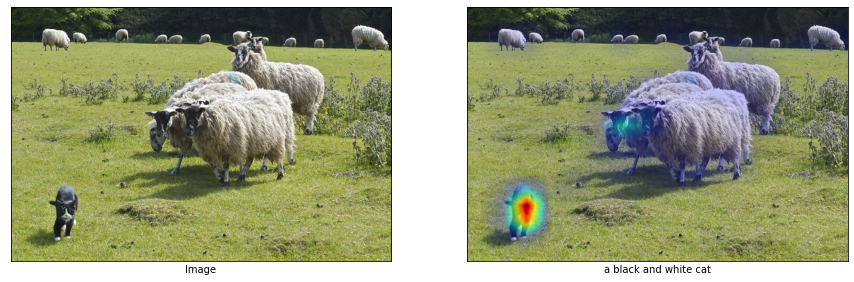

In [27]:
gradcam = get_phrase_gradcam(text, image, model)
gradcam_shown = gradcam.view(1,1,16,16)
gradcam_shown = F.interpolate(
    gradcam_shown, (256,256), mode="bilinear", align_corners=False
).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(15,20))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
word = text
gradcam_image = getAttMap(rgb_image, gradcam_shown.detach().cpu(), blur = False,overlap = True)
ax[1].imshow(gradcam_image)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(word)